In [1]:
# append parent directory to path for jupyter
import os
import sys

root_path = os.path.abspath(os.path.dirname(os.getcwd()))
sys.path.append(root_path)

In [2]:
from src.load_datasets import get_mnist_loader, get_fmnist_loader
from src.utils import seed_everything, load_config
from src.plotting import plot_loss_curve, plot_reconstruction, plot_samples_from_dataloader

In [3]:
from pprint import pp

yaml_path = "../configs/notebook_config.yml"
config = load_config(yaml_path)

pp(config)

{'seed': 0,
 'dataset': 'mnist',
 'data_dir': '../data',
 'device': 'cuda:0',
 'batch_size': 512,
 'learning_rate': 0.01,
 'weight_decay': 0.0,
 'train_epochs': 10,
 'sched_gamma': 0.999,
 'img_height': 28,
 'img_width': 28,
 'hidden_dim': 128,
 'latent_dim': 32,
 'n_layers': 3,
 'layernorm': False}


In [4]:
# set random seeds
seed_everything(config["seed"])

In [5]:
# load logging
import logging

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)

In [6]:
logger.info(
    f"Loading {config['dataset']} dataset with batch size {config['batch_size']}"
)

if config["dataset"] == "mnist":
    trainloader, testloader = get_mnist_loader(
        config["data_dir"], batch_size=config["batch_size"]
    )
elif config["dataset"] == "fmnist":
    trainloader, testloader = get_fmnist_loader(
        config["data_dir"], batch_size=config["batch_size"]
    )
else:
    logger.error("Dataset must be either 'mnist' or 'fmnist' ")

2024-10-01 05:05:11,817 - INFO - Loading mnist dataset with batch size 512


2024-10-01 05:05:26,637 - INFO - Plotting samples from Train Loader


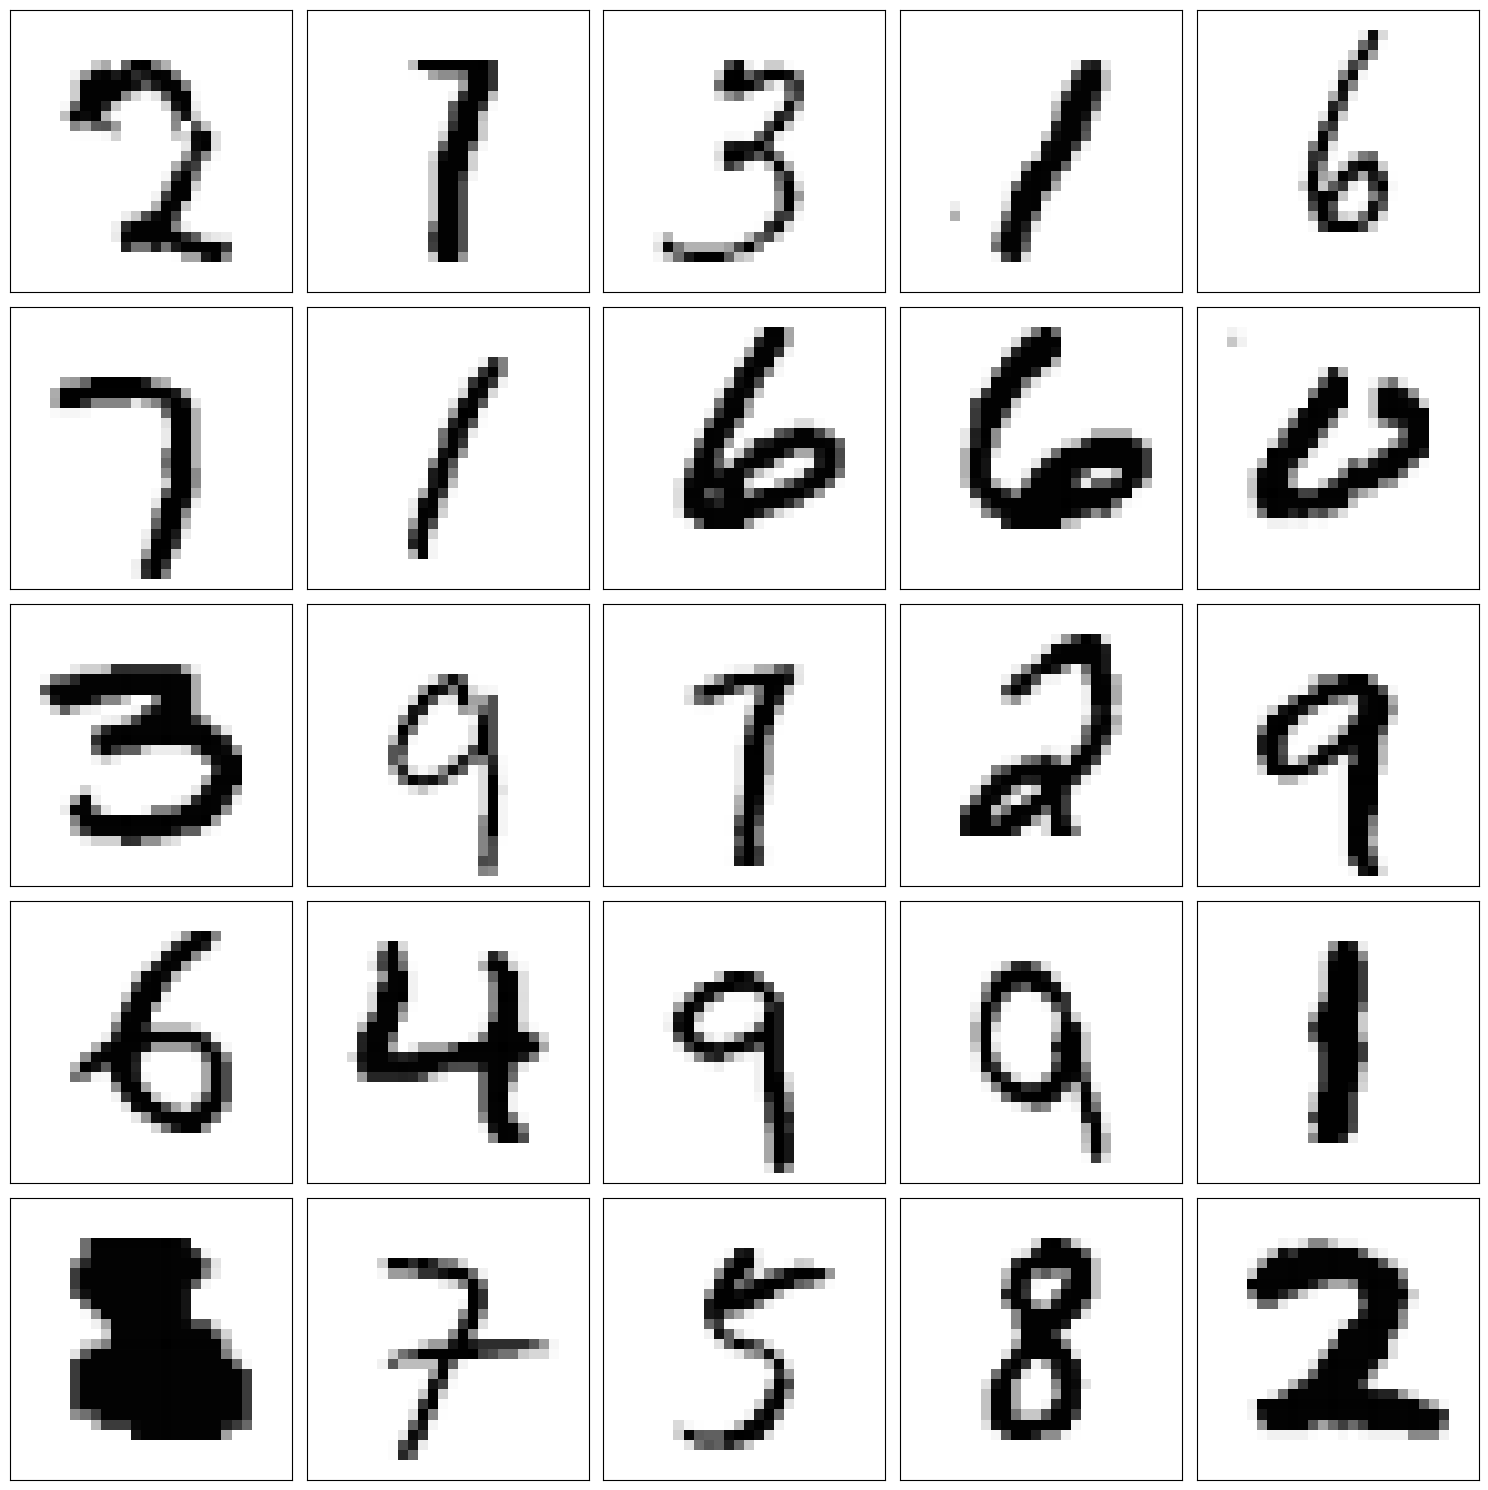

In [8]:
logger.info(f"Plotting samples from Train Loader")
plot_samples_from_dataloader(trainloader)

In [9]:
from src.train import Trainer
from src.models import Autoencoder
logger.info(f"Initializing Model")

model = Autoencoder(
    config["img_height"],
    config["img_width"],
    config["hidden_dim"],
    config["latent_dim"],
    config["n_layers"],
    layernorm=config["layernorm"],
)
model = model.to(config["device"])


logger.info(f"Training Model")

trainer = Trainer(model, trainloader, testloader, logger)
results = trainer.train(
    learning_rate=config["learning_rate"],
    weight_decay=config["weight_decay"],
    train_epochs=config["train_epochs"],
    sched_gamma=config["sched_gamma"],
    device=config["device"],
)

logger.info(f"Training Complete!")

2024-10-01 05:05:59,383 - INFO - Initializing Model
2024-10-01 05:05:59,609 - INFO - Training Model
2024-10-01 05:05:59,611 - INFO - Setting up Optimizer and Scheduler
2024-10-01 05:06:07,432 - INFO - epoch: 0	Train loss: 0.000453	Val loss: 0.000318	learning rate: 0.008886
2024-10-01 05:06:15,007 - INFO - epoch: 1	Train loss: 0.000266	Val loss: 0.000227	learning rate: 0.007897
2024-10-01 05:06:22,724 - INFO - epoch: 2	Train loss: 0.000208	Val loss: 0.000190	learning rate: 0.007018
2024-10-01 05:06:30,435 - INFO - epoch: 3	Train loss: 0.000179	Val loss: 0.000172	learning rate: 0.006236
2024-10-01 05:06:38,088 - INFO - epoch: 4	Train loss: 0.000160	Val loss: 0.000153	learning rate: 0.005542
2024-10-01 05:06:45,778 - INFO - epoch: 5	Train loss: 0.000147	Val loss: 0.000143	learning rate: 0.004925
2024-10-01 05:06:53,403 - INFO - epoch: 6	Train loss: 0.000139	Val loss: 0.000135	learning rate: 0.004376
2024-10-01 05:07:01,424 - INFO - epoch: 7	Train loss: 0.000132	Val loss: 0.000130	learning

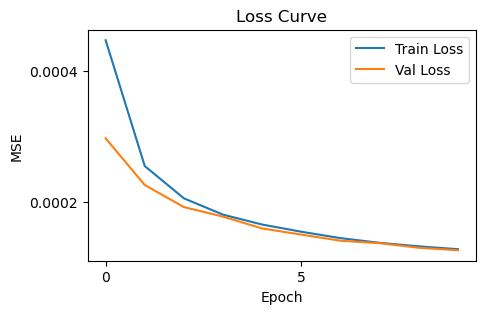

In [9]:
logger.info(f"Plotting loss curve plot")
plot_loss_curve(results, None)

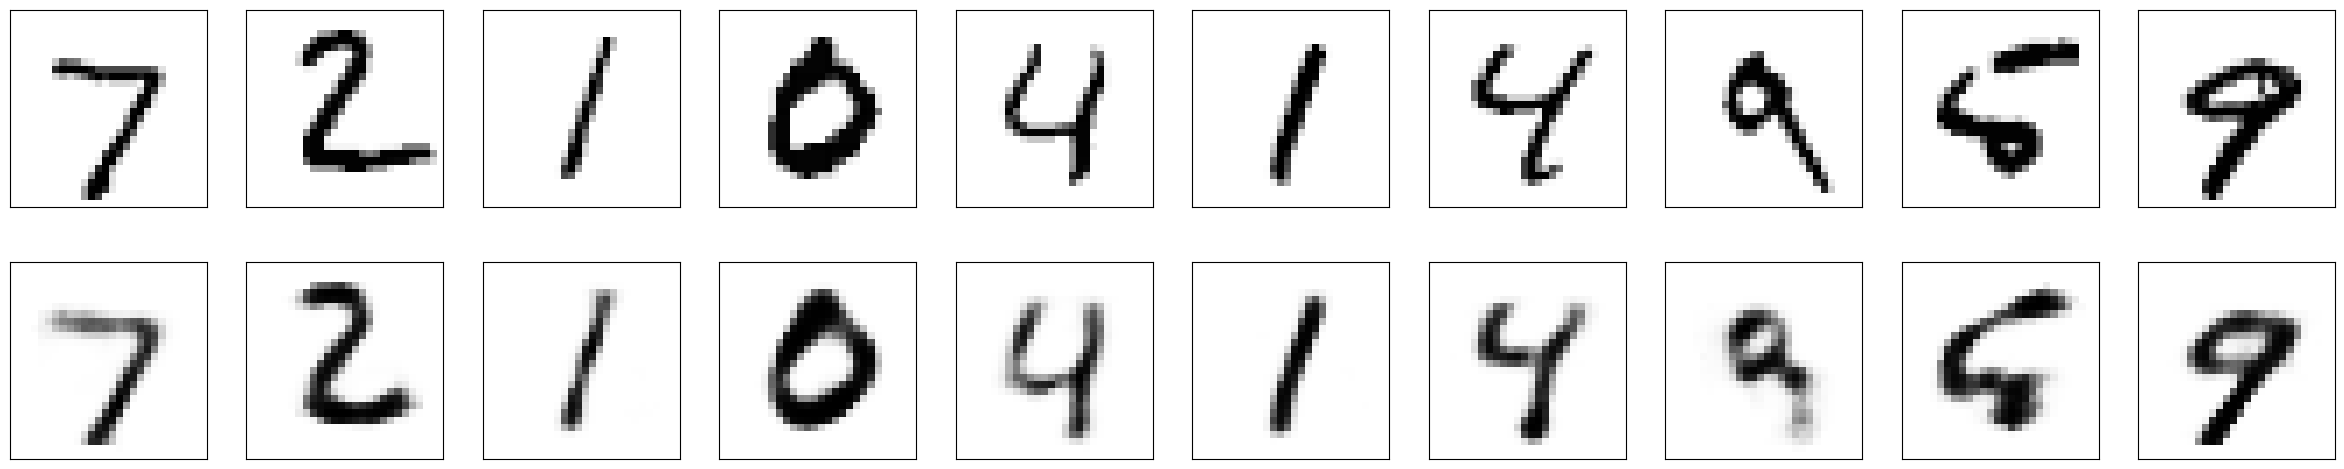

In [10]:
import torch

# plot inference for a single batch from the val set
with torch.no_grad():
    img, label = next(iter(testloader))
    img = img.to(config["device"])
    reconstructed = model(img)
    img = img.cpu()
    reconstructed = reconstructed.cpu()

plot_reconstruction(img, reconstructed)
